In [1]:
import os
from math import pi

# Use 8 CPU devices
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

# os.environ["CUDA_VISIBLE_DEVICES"] = "2,3 "  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit, pmap
from jax import random

jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, MN_POTENTIAL, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1)]

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

SimulationConfig(N_particles=100000, dimensions=3, return_snapshots=False, num_snapshots=100, fixed_timestep=True, num_timesteps=100, softening=0.010000000000000002, integrator=0, acceleration_scheme=3, batch_size=100000, double_map=False, external_accelerations=(0, 2))
SimulationParams(G=1, t_end=0.6707087409203456, Plummer_params=PlummerParams(a=0.1, Mtot=1.0), NFW_params=NFWParams(Mvir=10000.0, r_s=1.0, c=0.0, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=650.0, a=0.30000000000000004, b=0.03))


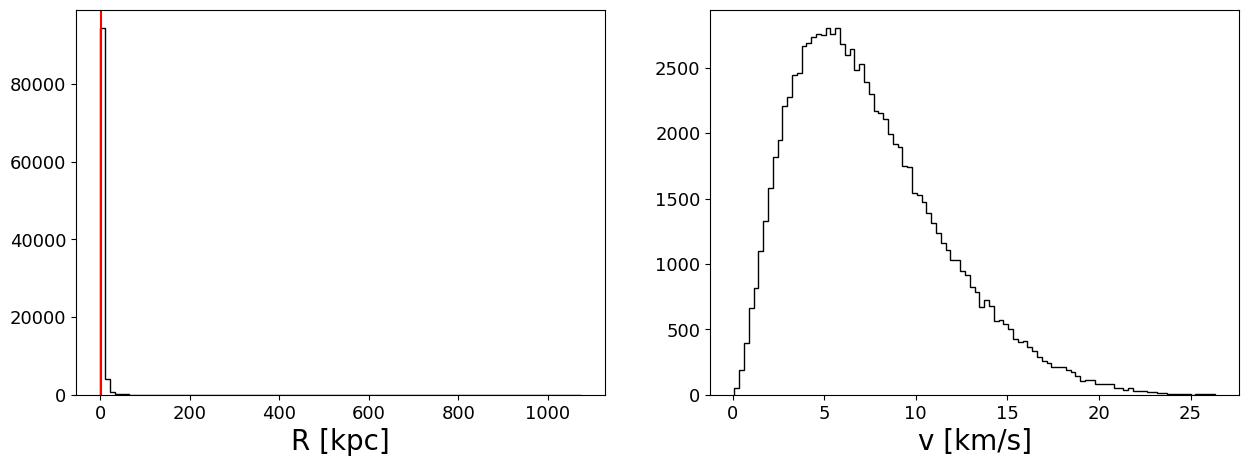

In [3]:
# Define the 
config = SimulationConfig(N_particles=100_000, 
                          return_snapshots=False, 
                          num_snapshots=100, 
                          num_timesteps=1_00, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC_FOR_LOOP,
                          batch_size=100_000,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (1 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (10.0 * u.kpc).to(code_units.code_length).value,
                                               c = 0.0),
                          G=G, ) 

print(config)
print(params)
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
initial_state = construct_initial_state(positions, velocities)


#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()




In [ ]:
snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))

NameError: unbound axis name: N_particles

: 

In [ ]:
from jax.sharding import Mesh, PartitionSpec as P
 
P('name')

PartitionSpec('name',)

In [ ]:
from jax.sharding import PositionalSharding
import equinox as eqx

sharding = PositionalSharding(jax.devices())
G = jax.local_device_count()


shared_positions = jax.device_put(positions, sharding.reshape(G, 1))
shared_velocities = jax.device_put(velocities, sharding.reshape(G, 1))
print(shared_positions.shape)
print(shared_positions.devices())

inital_state = construct_initial_state(shared_positions, shared_velocities)
mass = jax.device_put(mass, sharding.reshape(G))
print(inital_state.shape)
print(inital_state.devices())


print(initial_state.dtype)
print(mass.dtype)

(100000, 3)
{CudaDevice(id=1), CudaDevice(id=0)}
(100000, 2, 3)
{CudaDevice(id=1), CudaDevice(id=0)}
float64
float64


In [ ]:
from jax.sharding import PositionalSharding
import equinox as eqx

sharding = PositionalSharding(jax.devices())
G = jax.local_device_count()


shared_positions = jax.device_put(positions, sharding.reshape(G, 1))
shared_velocities = jax.device_put(velocities, sharding.reshape(G, 1))
print(shared_positions.shape)
print(shared_positions.devices())

inital_state = construct_initial_state(shared_positions, shared_velocities)
mass = jax.device_put(mass, sharding.reshape(G))
print(inital_state.shape)
print(inital_state.devices())


print(initial_state.dtype)
print(mass.dtype)

In [ ]:
# from jax.experimental import checkify

# errors = checkify.user_checks | checkify.index_checks | checkify.float_checks 
# def check_f(func):
#     return checkify.checkify(func, errors=errors)

# f = check_f(jax.block_until_ready(time_integration))

# err, snap = f(inital_state, mass, config, params)



snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))

XlaRuntimeError: INVALID_ARGUMENT: during context [hlo verifier]: Binary op compare with different element types: s64[] and s32[].
	, for instruction %compare.75 = pred[] compare(s64[] %select.56, s32[] %multiply.345), direction=GE, metadata={op_name="jit(time_integration)/jit(main)/jit(_time_integration_fixed_steps)/while/body/jit(leapfrog)/jit(direct_acc_laxmap)/while/body/dynamic_update_slice" source_file="/export/home/vgiusepp/Odisseo/odisseo/dynamics.py" source_line=143}

Failed after pipeline-start

In [ ]:
sharding

PositionalSharding([{GPU 0} {GPU 1}], memory_kind=device, shape=(2,))

In [ ]:
from jax.debug import visualize_array_sharding
import matplotlib as mpl

def visualize(tensor, color_map="Set3"):
    visualize_array_sharding(tensor, color_map=mpl.colormaps[color_map])
   
visualize(shared_positions)

         
         
  GPU 0  
         
         
         
         
         
  GPU 1  
         
         
         

In [ ]:
shared_positions.sharding

PositionalSharding([[{GPU 0}]
                    [{GPU 1}]], memory_kind=device, shape=(2, 1))

In [ ]:
position_replicated = jax.device_put(positions)

In [ ]:
(positions[0][None, :] - shared_positions).devices()

{CudaDevice(id=0), CudaDevice(id=1)}

In [ ]:
from jax.experimental.shard_map import shard_map


# 🚀 **Step 3: Compute Pairwise Distances Efficiently**
def compute_local_forces(local_positions, global_positions):
    """Compute sum of forces for a sharded chunk."""
    local_diff = local_positions[:, None] - global_positions[None, :]
    
    print(local_diff.shape)
    # Sum over all particles for each local piece
    return jnp.sum(local_diff, axis=1)

# 🚀 **Step 4: Parallelize Across GPUs Using `pmap`**
parallel_force_computation = shard_map(compute_local_forces, )

# Run computation
forces = parallel_force_computation(shared_positions, position_replicated)


TypeError: shard_map() missing 3 required positional arguments: 'mesh', 'in_specs', and 'out_specs'

In [ ]:
jax.lax.fori_loop(0, 10, lambda i, x: i+x, jnp.array([0]))

Array([45], dtype=int64)

In [3]:
from functools import partial

import jax
import jax.numpy as jnp

from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
from jax.experimental.shard_map import shard_map

In [4]:
mesh = jax.make_mesh((3, 1), ('x', 'y'))

shared_positions= jax.device_put(positions, NamedSharding(mesh, P('x', 'y')))
position_replicated = jax.device_put(positions)
                                 
@partial(shard_map, mesh=mesh, in_specs=(P('x', 'y'), P('y', None)), out_specs=P('x', None))
def reciprocal_distance(global_position, local_position):
    distance = global_position - local_position
    print(distance.shape)   
    return distance

distances = reciprocal_distance(position_replicated, shared_positions)

ValueError: Number of devices 2 must be >= the product of mesh_shape (3, 1)

# shard map again

In [3]:
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental import shard_map

# Create a mesh from all devices
devices = jax.devices()
mesh = Mesh(devices, axis_names=('x',))
# Define sharding strategy - shard along axis 0
sharding = jax.sharding.NamedSharding(mesh, P('x', None))

@partial(jit, static_argnames=('sharding'))
def shard_positions_with_shard_map(positions, sharding):
    """
    Shards positions across available devices along axis 0 using shard_map.
    
    Args:
        positions: Array of shape (n, d) to be sharded
        
    Returns:
        Tuple of (sharded_positions, mesh, sharding)
    """
    
    
    # Shard the positions array
    sharded_positions = jax.device_put(positions, sharding)
    
    return sharded_positions

# Create a replicated array for batch_positions
batch_sharding = jax.sharding.NamedSharding(mesh, P(None, None))
@partial(jit, static_argnames=('batch_sharding'))
def calculate_pairwise_distances_with_shard_map(sharded_positions, batch_positions, batch_sharding, ):
    """
    Calculates pairwise distances between sharded positions and a batch of positions using shard_map.
    
    Args:
        sharded_positions: Positions sharded across devices
        batch_positions: Array of positions to calculate distances with
        mesh: Device mesh used for sharding
        sharding: Sharding specification
        
    Returns:
        Array of all pairwise distances
    """
    
    batch_positions = jax.device_put(batch_positions, batch_sharding)
    
    def distance_fn(positions_shard):
        """Calculate pairwise distances between points in shard and batch"""
        squared_diff = jnp.sum((positions_shard[:, None, :] - batch_positions[None, :, :]) ** 2, axis=-1)
        return jnp.sqrt(squared_diff)
    
    # Map the computation across shards
    in_shardings = (P('x', None),)
    out_shardings = P('x', None)
    
    with mesh:
        mapped_fn = shard_map.shard_map(
            distance_fn,
            mesh=mesh,
            in_specs=in_shardings,
            out_specs=out_shardings
        )
        
        # Calculate distances
        distances = mapped_fn(sharded_positions)
    
    # Return the result
    return distances

# Example usage
@partial(jit, static_argnames=('sharding', 'batch_sharding'))
def compute_pairwise_distances(positions, query_positions, sharding, batch_sharding):
    """
    End-to-end function to calculate pairwise distances.
    
    Args:
        positions: First set of positions to shard
        query_positions: Second set of positions to calculate distances with
        
    Returns:
        Array of pairwise distances
    """
    sharded_positions = shard_positions_with_shard_map(positions, sharding)
    distances = calculate_pairwise_distances_with_shard_map(
        sharded_positions, query_positions, batch_sharding)
    
    # The result is already gathered by shard_map
    return distances

In [4]:
devices = jax.devices()
mesh = Mesh(devices, axis_names=('x',))
# Define sharding strategy - shard along axis 0
sharding = jax.sharding.NamedSharding(mesh, P('x', None))
sharded_positions = jax.device_put(positions, sharding)

NameError: name 'positions' is not defined

In [5]:
sharded_positions = shard_positions_with_shard_map(positions, sharding)

NameError: name 'positions' is not defined

In [6]:
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.sharding import NamedSharding
from jax.experimental import shard_map

# Create a mesh from all devices
devices = jax.devices()
mesh = Mesh(devices, axis_names=('x',))
# Define sharding strategy - shard along axis 0
sharding = NamedSharding(mesh, P('x', None))




In [7]:
mesh

Mesh(device_ids=array([0, 1]), axis_names=('x',), axis_types={Auto: ('x',)})

In [8]:
sharding

NamedSharding(mesh=Mesh('x': 2), spec=PartitionSpec('x', None), memory_kind=unpinned_host)

In [9]:
mesh = Mesh(devices, axis_names=('N_particles',))
sharding = NamedSharding(mesh, P('N_particles', None))
a = jnp.ones((10, 3))
a_sharded = jax.device_put(a, sharding) 
print("Sharded array", a_sharded)
print("Device", a_sharded.devices())
print("Sharding", a_sharded.sharding)

Sharded array [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
Device {CpuDevice(id=0), CpuDevice(id=1)}
Sharding NamedSharding(mesh=Mesh('N_particles': 2), spec=PartitionSpec('N_particles', None), memory_kind=unpinned_host)


In [10]:
jax.debug.visualize_array_sharding(a_sharded)

         
         
  CPU 0  
         
         
         
         
         
  CPU 1  
         
         
         

In [20]:
distance_a = jnp.sum((a[0, None] - a_sharded[None, :])**2, axis=1)

In [21]:
jax.debug.visualize_array_sharding(distance_a)

                                                                           
                                                                           
                                                                           
                                                                           
                                                                           
                                  CPU 0,1                                  
                                                                           
                                                                           
                                                                           
                                                                           
                                                                           

In [22]:
distance_a

Array([[0., 0., 0.]], dtype=float64)

In [ ]:
a.shape

(10, 3)

In [ ]:
@jit
def func(a):
    return jnp.sum((a[0, None] - a_sharded)**2, axis=1)
@jit
def lax_map_func(a):
    return jax.lax.map(func, a, batch_size=4)

from jax.experimental.shard_map import shard_map

dpos = shard_map(lax_map_func, mesh=mesh, in_specs=P('N_particles', None), out_specs=P('N_particles', None))(a_sharded)
dpos = jax.device_put(dpos, devices[0])
print(dpos.shape)
print(dpos.sharding)
jax.debug.visualize_array_sharding(dpos)

(10, 10)
SingleDeviceSharding(device=CudaDevice(id=0), memory_kind=device)


                         
                         
                         
                         
                         
          GPU 0          
                         
                         
                         
                         
                         

In [ ]:
initial_state = construct_initial_state(a_sharded, a)
mass = jnp.ones_like(initial_state[:, 0, 0])

def time_integration_sharded(initial_state, ):
    return time_integration(initial_state, mass, config, params)

snapshots = jax.block_until_ready(shard_map(time_integration_sharded, 
                                            mesh=mesh, 
                                            in_specs=(P('N_particles', None), ),
                                            out_specs=(P('N_particles', None),)))(initial_state, )

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 5: axis 0 of argument particle_j of type float64[5,2,3];
  * one axis had size 10: axis 0 of argument mass_j of type float64[10]

In [ ]:
@jit
def put_on_device(a):
    # Create a mesh from all devices
    devices = jax.devices()
    mesh = Mesh(devices, axis_names=('x',))
    # Define sharding strategy - shard along axis 0
    sharding = jax.sharding.NamedSharding(mesh, P('x', None))
    a_sharded = jax.device_put(a, sharding)
    return a_sharded

In [ ]:
put_on_device(a).devices()

{CudaDevice(id=0), CudaDevice(id=1)}